Preparing my colab environment

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/Colab Notebooks/CVFOLDER/CVPROJECT
import sys
path_to_module = '/content/gdrive/MyDrive/Colab Notebooks/CVFOLDER/CVPROJECT/'
sys.path.append(path_to_module)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/MyDrive/Colab Notebooks/CVFOLDER/CVPROJECT'
/content/gdrive/MyDrive/Colab Notebooks/CVFOLDER/CVPROJECT


In [ ]:
!pip install disarray #this is not on colab and needs to be installe > converts confusion matrix to metrics

and importing necessary libraries

In [ ]:
import os
import re
import sys
import time
import cv2
import models.mask_net as mask_net
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import utils
from PIL import Image as PILImage
from models.mask_net.faster_rcnn import FastRCNNPredictor, TwoMLPHead
from models.mask_net.rpn import AnchorGenerator
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
import pandas as pd
import disarray

The details are like previous notebook notesbooks , getting parameters from config dict and so on

In [ ]:
def main(config):
    torch.manual_seed(time.time())
    start_time = time.time()
    pretrained_model= config["ckpt"]
    model_name=config["model_name"]
    test_data_dir=config["test_data_dir"]
    device=config["device"]
    rpn_nms=config["rpn_nms_th"]
    roi_nms=config["roi_nms_th"]
    backbone_name=config["backbone_name"]
    truncation=config["truncation"]
    roi_batch_size=config["roi_batch_size"]
    n_c=config["num_classes"]
    s_features=config["s_features"]

    if torch.cuda.is_available() and device == 'cuda':
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    print(device)
    # either 2+1 or 1+1 classes
    ckpt = torch.load(pretrained_model, map_location=device)
    # 'box_detections_per_img': batch size input in module S
    # 'box_score_thresh': negative to accept all predictions
    covid_mask_net_args = {'num_classes': None, 'min_size': 512, 'max_size': 1024, 'box_detections_per_img': roi_batch_size,
                           'box_nms_thresh': roi_nms, 'box_score_thresh': -0.01, 'rpn_nms_thresh': rpn_nms}

    print(covid_mask_net_args)
    # extract anchor generator from the checkpoint
    sizes = ckpt['anchor_generator'].sizes
    aspect_ratios = ckpt['anchor_generator'].aspect_ratios
    anchor_generator = AnchorGenerator(sizes, aspect_ratios)
    # Faster R-CNN interfaces, masks not implemented at this stage
    box_head = TwoMLPHead(in_channels=256*7*7, representation_size=128)
    box_predictor = FastRCNNPredictor(in_channels=128, num_classes=n_c)
    # Mask prediction is not necessary, keep it for future extensions
    covid_mask_net_args['rpn_anchor_generator'] = anchor_generator
    covid_mask_net_args['box_predictor'] = box_predictor
    covid_mask_net_args['box_head'] = box_head
    # representation size of the S classification module
    # these should be provided in the config
    covid_mask_net_args['s_representation_size'] = s_features
    # Instance of the model, copy weights
    covid_mask_net_model = mask_net.fasterrcnn_resnet_fpn(backbone_name, truncation, **covid_mask_net_args)
    covid_mask_net_model.load_state_dict(ckpt['model_weights'])
    covid_mask_net_model.eval().to(device)
    print(covid_mask_net_model)
    # confusion matrix
    confusion_matrix = torch.zeros(3, 3, dtype=torch.int32).to(device)

    for idx, f in enumerate(tqdm(os.listdir(test_data_dir))):
        test_step(f, covid_mask_net_model, test_data_dir, device, confusion_matrix)
    print("------------------------------------------")
    print("Confusion Matrix for 3-class problem:")
    print("0: Control, 1: Normal Pneumonia, 2: COVID")
    print(confusion_matrix)
    print("------------------------------------------")
    # confusion matrix
    cm = confusion_matrix.float()
    cm[0, :].div_(cm[0, :].sum())
    cm[1, :].div_(cm[1, :].sum())
    cm[2, :].div_(cm[2, :].sum())
    print("------------------------------------------")
    print("Class Sensitivity:")
    print(cm)
    print("------------------------------------------")
    print('Overall accuracy:')
    print(confusion_matrix.diag().float().sum().div(confusion_matrix.sum()))
    end_time = time.time()
    classes=("0: Control", "1: Common Pneumonia", " 2: COVID-19")
    normalize=True
    plot_confusion_matrix(cm,confusion_matrix,classes,normalize,'confusion_matrix',cmap=plt.cm.Blues)
    print("Evaluation took {0:.1f} seconds".format(end_time - start_time))

the only point is to compare predicted label with actual class extracted from labels

In [ ]:
def test_step(im_input, model, source_dir, device, c_matrix):
    correct_class = int(im_input.split('/')[-1].split('_')[0])
    im = PILImage.open(os.path.join(source_dir, im_input))
    if im.mode != 'RGB':
        im = im.convert(mode='RGB')
    # get rid of alpha channel
    img = np.array(im)
    # print(img)
    if img.shape[2] > 3:
        img = img[:, :, :3]
    t_ = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(512),
        transforms.ToTensor()])
    img = t_(img)
    if device == torch.device('cuda'):
        img = img.to(device)
    out = model([img])
    pred_class = out[0]['final_scores'].argmax().item()
    # get confusion matrix
    c_matrix[correct_class, pred_class] += 1

of previous stages we have confusion matrix but lets visulize it
in this code you can uncomment some lines to have TP,TN, etc

In [ ]:
def plot_confusion_matrix(cm,confusion_matrix, classes, normalize, title='Confusion matrix', cmap=plt.cm.Blues):
    cm=cm.cpu().data.numpy()
    confusion_matrix=confusion_matrix.cpu().data.numpy()
   # TP = np.diag(cm)
   # FP = np.sum(cm, axis=0) - TP
   # FN = np.sum(cm, axis=1) - TP
   # num_classes = len(classes)
   # TN = []
    #for i in range(num_classes):
     #   temp = np.delete(cm, i, 0)    # delete ith row
      #  temp = np.delete(temp, i, 1)  # delete ith column
      #  TN.append(sum(sum(temp)))
    #precision = TP/(TP+FP)
    #recall = TP/(TP+FN)
    #specificity = TN/(TN+FP)
    df = pd.DataFrame(confusion_matrix,dtype=int)
    print(df.da.export_metrics())

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

last but first :D line to run


cuda
{'num_classes': None, 'min_size': 512, 'max_size': 1024, 'box_detections_per_img': 256, 'box_nms_thresh': 0.75, 'box_score_thresh': -0.01, 'rpn_nms_thresh': 0.75}
FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

100%|██████████| 1000/1000 [00:52<00:00, 19.05it/s]


------------------------------------------
Confusion Matrix for 3-class problem:
0: Control, 1: Normal Pneumonia, 2: COVID
tensor([[423,   8,   0],
        [ 10, 336,   5],
        [  0,  11, 207]], device='cuda:0', dtype=torch.int32)
------------------------------------------
------------------------------------------
Class Sensitivity:
tensor([[0.9814, 0.0186, 0.0000],
        [0.0285, 0.9573, 0.0142],
        [0.0000, 0.0505, 0.9495]], device='cuda:0')
------------------------------------------
Overall accuracy:
tensor(0.9660, device='cuda:0')
                                  0         1         2  micro-average
accuracy                   0.982000  0.966000  0.984000       0.977333
f1                         0.979167  0.951841  0.962791       0.966000
false_discovery_rate       0.023095  0.053521  0.023585       0.034000
false_negative_rate        0.018561  0.042735  0.050459       0.034000
false_positive_rate        0.017575  0.029276  0.006394       0.017000
negative_predictive_v

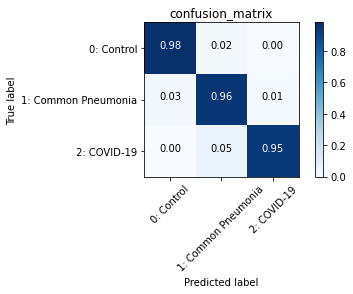

In [ ]:
# run the inference
if __name__ == '__main__':
    config_dict = { "model_name": None,
        "device": "cuda",
        "roi_nms_th": 0.75,
        "roi_batch_size": 256,
        "rpn_nms_th": 0.75,
        "backbone_name": "resnet50",
        "truncation": '0',
        "num_classes": 3,
        "s_features": 1024,
        "ckpt": "Classification_folder/saved_models__checkpoints__/Alireza_model__ckpt_60.pth" ,
        "test_data_dir":"Classification_folder/covid_data/cncb/test/"}
    main(config_dict)